In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Flatten, Concatenate, BatchNormalization
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

In [2]:
ratings = pd.read_csv('ratings_final.csv')
movies_data = pd.read_csv('movies_data_final.csv')
users_data_title = ['userId', 'gender', 'age', 'occupationId', 'zipcode']
users_data = pd.read_csv('users.dat', sep='::', header=None, names=users_data_title , engine = 'python')

In [3]:
ratings.head(), ratings.shape

(   userId  movieId  rating   timestamp
 0       1       31     2.5  1260759144
 1       1     1029     3.0  1260759179
 2       1     1061     3.0  1260759182
 3       1     1129     2.0  1260759185
 4       1     1172     4.0  1260759205,
 (99810, 4))

In [4]:
movies_data.head()

,movieId,imdbId,tmdbId,cast,crew,director,keywords,adult,belongs_to_collection,budget,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,1,114709,862.0,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",John Lasseter,jealousy|toy|boy|friendship|friends|rivalry|bo...,False,Toy Story Collection,30000000,...,373554033.0,81.0,English,Released,NaN,Toy Story,False,7.7,5415.0,1995
1,2,113497,8844.0,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,"[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",Joe Johnston,board game|disappearance|based on children's b...,False,NaN,65000000,...,262797249.0,104.0,English|Français,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,3,113228,15602.0,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia ...,"[{'credit_id': '52fe466a9251416c75077a89', 'de...",Howard Deutch,fishing|best friend|duringcreditsstinger|old men,False,Grumpy Old Men Collection,0,...,0.0,101.0,English,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,4,114885,31357.0,Whitney Houston|Angela Bassett|Loretta Devine|...,"[{'credit_id': '52fe44779251416c91011acb', 'de...",Forest Whitaker,based on novel|interracial relationship|single...,False,NaN,16000000,...,81452156.0,127.0,English,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,5,113041,11862.0,Steve Martin|Diane Keaton|Martin Short|Kimberl...,"[{'credit_id': '52fe44959251416c75039ed7', 'de...",Charles Shyer,baby|midlife crisis|confidence|aging|daughter|...,False,Father of the Bride Collection,0,...,76578911.0,106.0,English,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [5]:
users_data.head()

,userId,gender,age,occupationId,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
gender_one_hot = pd.get_dummies(users_data['gender'], prefix='gender')
age_one_hot = pd.get_dummies(users_data['age'], prefix='age')
occupationId_one_hot = pd.get_dummies(users_data['occupationId'], prefix='occupationId')


In [7]:
users_data_encoded = pd.concat([users_data, gender_one_hot, age_one_hot, occupationId_one_hot], axis=1)
users_data_encoded = users_data_encoded.drop(['gender', 'age', 'occupationId'], axis=1)
users_data_encoded

,userId,zipcode,gender_F,gender_M,age_1,age_18,age_25,age_35,age_45,age_50,...,occupationId_11,occupationId_12,occupationId_13,occupationId_14,occupationId_15,occupationId_16,occupationId_17,occupationId_18,occupationId_19,occupationId_20
0,1,48067,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,70072,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,55117,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,02460,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,55455,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,6036,32603,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6036,6037,76006,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6037,6038,14706,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,6039,01060,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# users_data_encoded.to_csv('one_hot_encode_user_data.csv', index= False)

In [9]:
ratings = pd.merge(ratings, users_data_encoded , on = 'userId', how='inner')
ratings

,userId,movieId,rating,timestamp,zipcode,gender_F,gender_M,age_1,age_18,age_25,...,occupationId_11,occupationId_12,occupationId_13,occupationId_14,occupationId_15,occupationId_16,occupationId_17,occupationId_18,occupationId_19,occupationId_20
0,1,31,2.5,1260759144,48067,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1029,3.0,1260759179,48067,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1061,3.0,1260759182,48067,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1129,2.0,1260759185,48067,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1172,4.0,1260759205,48067,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99805,671,6268,2.5,1065579370,61761,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
99806,671,6269,4.0,1065149201,61761,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
99807,671,6365,4.0,1070940363,61761,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
99808,671,6385,2.5,1070979663,61761,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
movies_data_useful = movies_data[['movieId', 'cast', 'director', 'keywords', 'budget', 'genres', 'overview', 'production_companies', 'title']]

In [11]:
genre_one_hot = movies_data_useful['genres'].str.get_dummies(sep='|')
movies_data_useful = pd.concat([movies_data_useful, genre_one_hot], axis = 1)

In [12]:
genre_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music',
       'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War',
       'Western']

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

actor_genre_dict = {}
director_genre_dict = {}
production_companies_genre_dict = {}
for ind, row in movies_data_useful.iterrows():
    try: 
        casts = row['cast'].split("|")
        for member in casts:
            if member in actor_genre_dict:
                    actor_genre_dict[member] = [actor_genre_dict[member][i] + row[genre_list[i]] for i in range(len(genre_list))]
            else:
                    actor_genre_dict[member] = [0 + row[genre_list[i]] for i in range(len(genre_list))]
    except:
        pass
    
    try: 
        directors = row['director'].split("|")
        for member in directors:
            if member in director_genre_dict:
                    director_genre_dict[member] = [director_genre_dict[member][i] + row[genre_list[i]] for i in range(len(genre_list))]
            else:
                    director_genre_dict[member] = [0 + row[genre_list[i]] for i in range(len(genre_list))]
    except:
        pass
    
    try: 
        production_companies = row['production_companies'].split("|")
        for member in production_companies:
            if member in production_companies_genre_dict:
                    production_companies_genre_dict[member] = [production_companies_genre_dict[member][i] + row[genre_list[i]] for i in range(len(genre_list))]
            else:
                    production_companies_genre_dict[member] = [0 + row[genre_list[i]] for i in range(len(genre_list))]
    except:
        pass
# print(actor_genre_dict)

cast_one_hot_encoded = []
production_companies_one_hot_encoded = []
director_one_hot_encoded = []

for ind, row in movies_data_useful.iterrows():
# for ind, row in movies_data_useful.head(2).iterrows():
    val = [0 for i in range(len(genre_list))]
    try:
        casts = row['cast'].split("|")
        n = len(casts)
        for member in casts:
            val = [actor_genre_dict[member][i] + (val[i]/n)  for i in range(len(genre_list))]
        # val = [sigmoid(val[i]) for i in range(len(genre_list))]
    except:
        pass
    cast_one_hot_encoded.append(val)
    
    val = [0 for i in range(len(genre_list))]
    try:
        directors = row['director'].split("|")
        n = len(directors)
        for member in directors:
            val = [director_genre_dict[member][i] + (val[i]/n) for i in range(len(genre_list))]
        # val = [sigmoid(val[i]) for i in range(len(genre_list))]
    except:
        pass
    director_one_hot_encoded.append(val)
    
    val = [0 for i in range(len(genre_list))]
    try:
        production_companies = row['production_companies'].split("|")
        n = len(production_companies)
        for member in production_companies:
            val = [production_companies_genre_dict[member][i] + (val[i]/n)  for i in range(len(genre_list))]
        # val = [sigmoid(val[i]) for i in range(len(genre_list))]
    except:
        pass
    production_companies_one_hot_encoded.append(val)
    
    
    
# print(cast_one_hot_encoded)    


In [13]:
# create an instance of MinMaxScaler
scaler = MinMaxScaler()

# fit and transform the data
cast_one_hot_normalized = scaler.fit_transform(cast_one_hot_encoded)
director_one_hot_normalized = scaler.fit_transform(director_one_hot_encoded) 
production_companies_one_hot_normalized = scaler.fit_transform(production_companies_one_hot_encoded) 

In [14]:
cast_one_hot_encoded_df = pd.DataFrame(cast_one_hot_normalized, columns=[f'cast_{i+1}' for i in range(len(cast_one_hot_normalized[0]))])
director_one_hot_encoded_df = pd.DataFrame(director_one_hot_normalized, columns=[f'director_{i+1}' for i in range(len(director_one_hot_normalized[0]))])
production_companies_one_hot_encoded_df = pd.DataFrame(production_companies_one_hot_normalized, columns=[f'production_companies_{i+1}' for i in range(len(production_companies_one_hot_normalized[0]))])

In [15]:
movies_data_useful = pd.concat([movies_data_useful, cast_one_hot_encoded_df, director_one_hot_encoded_df, production_companies_one_hot_encoded_df], axis=1)

In [16]:
# movies_data_useful.to_csv('one_hot_movie_data.csv', index=False)

In [17]:
movies_data_useful.head()

,movieId,cast,director,keywords,budget,genres,overview,production_companies,title,Action,...,production_companies_11,production_companies_12,production_companies_13,production_companies_14,production_companies_15,production_companies_16,production_companies_17,production_companies_18,production_companies_19,production_companies_20
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,jealousy|toy|boy|friendship|friends|rivalry|bo...,30000000,Animation|Comedy|Family,"Led by Woody, Andy's toys live happily in his ...",Pixar Animation Studios,Toy Story,0,...,0.000000,0.000000,0.000000,0.000000,0.005935,0.000000,0.0,0.000000,0.000000,0.000000
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,board game|disappearance|based on children's b...,65000000,Adventure|Fantasy|Family,When siblings Judy and Peter discover an encha...,TriStar Pictures|Teitler Film|Interscope Commu...,Jumanji,0,...,0.015595,0.027778,0.026403,0.065596,0.046159,0.048753,0.0,0.053221,0.048309,0.008081
2,3,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia ...,Howard Deutch,fishing|best friend|duringcreditsstinger|old men,0,Romance|Comedy,A family wedding reignites the ancient feud be...,Warner Bros.|Lancaster Gate,Grumpier Old Men,0,...,0.368421,0.193182,0.316832,0.427711,0.367953,0.306122,0.0,0.384454,0.347826,0.400000
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Forest Whitaker,based on novel|interracial relationship|single...,16000000,Comedy|Drama|Romance,"Cheated on, mistreated and stepped on, the wom...",Twentieth Century Fox Film Corporation,Waiting to Exhale,0,...,0.526316,0.284091,0.455446,0.289157,0.575668,0.775510,0.0,0.462185,0.608696,0.400000
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Charles Shyer,baby|midlife crisis|confidence|aging|daughter|...,0,Comedy,Just when George Banks has recovered from his ...,Sandollar Productions|Touchstone Pictures,Father of the Bride Part II,0,...,0.228070,0.034091,0.138614,0.144578,0.317507,0.193878,0.0,0.186975,0.173913,0.181818


In [18]:
movies_df = pd.merge(ratings, movies_data_useful, on='movieId', how='inner')

In [19]:
# movies_df.to_csv('movies_df.csv', index=False)

In [20]:
movies_df.head()

,userId,movieId,rating,timestamp,zipcode,gender_F,gender_M,age_1,age_18,age_25,...,production_companies_11,production_companies_12,production_companies_13,production_companies_14,production_companies_15,production_companies_16,production_companies_17,production_companies_18,production_companies_19,production_companies_20
0,1,31,2.5,1260759144,48067,1,0,1,0,0,...,0.023392,0.006313,0.008801,0.004016,0.01121,0.005669,0.0,0.027077,0.0,0.00404
1,7,31,3.0,851868750,06810,0,1,0,0,0,...,0.023392,0.006313,0.008801,0.004016,0.01121,0.005669,0.0,0.027077,0.0,0.00404
2,31,31,4.0,1273541953,06840,0,1,0,0,0,...,0.023392,0.006313,0.008801,0.004016,0.01121,0.005669,0.0,0.027077,0.0,0.00404
3,32,31,4.0,834828440,19355,1,0,0,0,1,...,0.023392,0.006313,0.008801,0.004016,0.01121,0.005669,0.0,0.027077,0.0,0.00404
4,36,31,3.0,847057202,94123,0,1,0,0,1,...,0.023392,0.006313,0.008801,0.004016,0.01121,0.005669,0.0,0.027077,0.0,0.00404


# DNN

In [21]:
userId_encoder = LabelEncoder()
movies_df['userId_encoded'] = userId_encoder.fit_transform(movies_df['userId'].values)
userId_count = movies_df['userId_encoded'].nunique() 

movieId_encoder = LabelEncoder()
movies_df['movieId_encoded'] = movieId_encoder.fit_transform(movies_df['movieId'].values)
movieId_count = movies_df['movieId_encoded'].nunique()

In [22]:
movies_df.head()

,userId,movieId,rating,timestamp,zipcode,gender_F,gender_M,age_1,age_18,age_25,...,production_companies_13,production_companies_14,production_companies_15,production_companies_16,production_companies_17,production_companies_18,production_companies_19,production_companies_20,userId_encoded,movieId_encoded
0,1,31,2.5,1260759144,48067,1,0,1,0,0,...,0.008801,0.004016,0.01121,0.005669,0.0,0.027077,0.0,0.00404,0,30
1,7,31,3.0,851868750,06810,0,1,0,0,0,...,0.008801,0.004016,0.01121,0.005669,0.0,0.027077,0.0,0.00404,6,30
2,31,31,4.0,1273541953,06840,0,1,0,0,0,...,0.008801,0.004016,0.01121,0.005669,0.0,0.027077,0.0,0.00404,30,30
3,32,31,4.0,834828440,19355,1,0,0,0,1,...,0.008801,0.004016,0.01121,0.005669,0.0,0.027077,0.0,0.00404,31,30
4,36,31,3.0,847057202,94123,0,1,0,0,1,...,0.008801,0.004016,0.01121,0.005669,0.0,0.027077,0.0,0.00404,35,30


In [23]:
y = movies_df['rating']
X = movies_df.drop(columns=['rating'])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [25]:
X_test.head(5)

,userId,movieId,timestamp,zipcode,gender_F,gender_M,age_1,age_18,age_25,age_35,...,production_companies_13,production_companies_14,production_companies_15,production_companies_16,production_companies_17,production_companies_18,production_companies_19,production_companies_20,userId_encoded,movieId_encoded
59354,380,5945,1070843893,92024,0,1,0,0,1,0,...,0.099010,0.102410,0.151335,0.163265,0.0,0.119748,0.000000,0.018182,379,4379
24547,466,344,944892302,55405,0,1,0,0,1,0,...,0.316832,0.512048,0.403561,0.346939,0.0,0.464286,0.434783,0.509091,465,309
76775,242,463,956685706,53706,1,0,0,1,0,0,...,0.079208,0.036145,0.083086,0.051020,0.0,0.079832,0.000000,0.036364,241,411
87259,624,102407,1401128048,75207,0,1,0,0,1,0,...,0.002951,0.003976,0.011398,0.006258,0.0,0.004277,0.008059,0.003704,623,8259
71534,28,933,938944683,14607,1,0,0,0,1,0,...,0.554455,0.698795,0.658754,0.622449,0.0,0.613445,0.289855,0.509091,27,750


In [26]:
userId_train , userId_test = X_train['userId_encoded'], X_test['userId_encoded']
gender_train, gender_test = X_train.filter(regex='^gender_'), X_test.filter(regex='^gender_')
age_train, age_test = X_train.filter(regex='^age_'), X_test.filter(regex='^age_')
occupationId_train, occupationId_test = X_train.filter(regex='^occupationId_'), X_test.filter(regex='^occupationId_')

movieId_train , movieId_test = X_train['movieId_encoded'], X_test['movieId_encoded']
genre_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music',
       'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War',
       'Western']
genre_train, genre_test = X_train[genre_list], X_test[genre_list]
cast_train, cast_test = X_train.filter(regex='^cast_'), X_test.filter(regex='^cast_')
director_train, director_test = X_train.filter(regex='^director_'), X_test.filter(regex='^director_')
production_companies_train, production_companies_test = X_train.filter(regex='^production_companies_'), X_test.filter(regex='^production_companies_')

In [32]:

# X_d_c_train, X_d_c_test
# Define the embedding sizes
userId_embedding_size = 16

gender_dimensions = 2
gender_embedding_size = 2

age_dimensions = 7
age_embedding_size = 7

occupationId_dimensions = 21
occupationId_embedding_size = 21

genre_count = 20
movieId_embedding_size = 16

genre_dimensions = genre_count
genre_embedding_size = 20

cast_dimensions = genre_count
cast_embedding_size = 20

director_dimensions = genre_count
director_embedding_size = 20

production_companies_dimensions = genre_count
production_companies_embedding_size = 20



userId_input = Sequential()
userId_input.add(Embedding(userId_count, userId_embedding_size, input_length=1))
userId_input.add(Flatten())

user_gender_input = Sequential()
user_gender_input.add(Dense(gender_embedding_size, input_dim=gender_dimensions, activation='relu'))

user_age_input = Sequential()
user_age_input.add(Dense(age_embedding_size, input_dim=age_dimensions, activation='relu'))

user_occupationId_input = Sequential()
user_occupationId_input.add(Dense(occupationId_embedding_size, input_dim=occupationId_dimensions, activation='relu'))


# Define the neural network model
movieId_input = Sequential()
movieId_input.add(Embedding(movieId_count, movieId_embedding_size, input_length=1))
movieId_input.add(Flatten())


genre_input = Sequential()
genre_input.add(Dense(genre_embedding_size, input_dim=genre_dimensions, activation='relu'))

director_input = Sequential()
director_input.add(Dense(director_embedding_size, input_dim=director_dimensions, activation='relu'))

cast_input = Sequential()
cast_input.add(Dense(cast_embedding_size, input_dim=cast_dimensions, activation='relu'))

production_companies_input = Sequential()
production_companies_input.add(Dense(production_companies_embedding_size, input_dim=production_companies_dimensions, activation='relu'))



# user_input_merged = Concatenate()([userId_input.output, user_gender_input.output, user_age_input.output, user_occupationId_input.output])
user_input_merged = Concatenate()([userId_input.output, user_gender_input.output, user_age_input.output, user_occupationId_input.output])
x = Dense(64, activation='relu')(user_input_merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)


# movie_input_merged = Concatenate()([movieId_input.output, genre_input.output, director_input.output, cast_input.output, production_companies_input.output])
movie_input_merged = Concatenate()([movieId_input.output, genre_input.output, director_input.output, cast_input.output, production_companies_input.output])
y = Dense(64, activation='relu')(movie_input_merged)
y = BatchNormalization()(y)
y = Dropout(0.2)(y)
y = Dense(128, activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.2)(y)

final_merged = Concatenate()([x, y])
# final = Dense(128, activation='relu')(final_merged)
# final = BatchNormalization()(final)
# final = Dropout(0.2)(final)
# final = Dense(10, activation='softmax')(final)
final = Dense(10, activation='softmax')(final_merged)


# Split the data into training and testing sets
model = Model(inputs=[userId_input.input, user_gender_input.input, user_age_input.input, user_occupationId_input.input, 
                      movieId_input.input, genre_input.input, director_input.input, cast_input.input, production_companies_input.input], 
              outputs=final)

# Compile the model with appropriate loss and optimizer
optimizer = Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])

# Train the model
history = model.fit([userId_train, gender_train, age_train, occupationId_train, 
                      movieId_train, genre_train, director_train, cast_train, production_companies_train], 
                    y_train_cat, epochs=20, batch_size=10000,
                    validation_data=([userId_test, gender_test, age_test, occupationId_test, 
                      movieId_test, genre_test, director_test, cast_test, production_companies_test], y_test_cat))


# Test the model
test_loss, test_mae = model.evaluate([userId_test, gender_test, age_test, occupationId_test, 
                      movieId_test, genre_test, director_test, cast_test, production_companies_test], y_test_cat)
print(f'Test MSE: {test_mae:.3f}')

Epoch 1/20
8/8 [==============================] - 7s 338ms/step - loss: 0.1448 - mae: 0.1448 - val_loss: 0.1488 - val_mae: 0.1488
Epoch 2/20
8/8 [==============================] - 2s 203ms/step - loss: 0.1232 - mae: 0.1232 - val_loss: 0.1266 - val_mae: 0.1266
Epoch 3/20
8/8 [==============================] - 2s 195ms/step - loss: 0.1152 - mae: 0.1152 - val_loss: 0.1189 - val_mae: 0.1189
Epoch 4/20
8/8 [==============================] - 1s 177ms/step - loss: 0.1103 - mae: 0.1103 - val_loss: 0.1163 - val_mae: 0.1163
Epoch 5/20
8/8 [==============================] - 1s 181ms/step - loss: 0.1074 - mae: 0.1074 - val_loss: 0.1157 - val_mae: 0.1157
Epoch 6/20
8/8 [==============================] - 1s 179ms/step - loss: 0.1057 - mae: 0.1057 - val_loss: 0.1157 - val_mae: 0.1157
Epoch 7/20
8/8 [==============================] - 2s 190ms/step - loss: 0.1042 - mae: 0.1042 - val_loss: 0.1153 - val_mae: 0.1153
Epoch 8/20
8/8 [==============================] - 1s 186ms/step - loss: 0.1034 - mae: 0.10

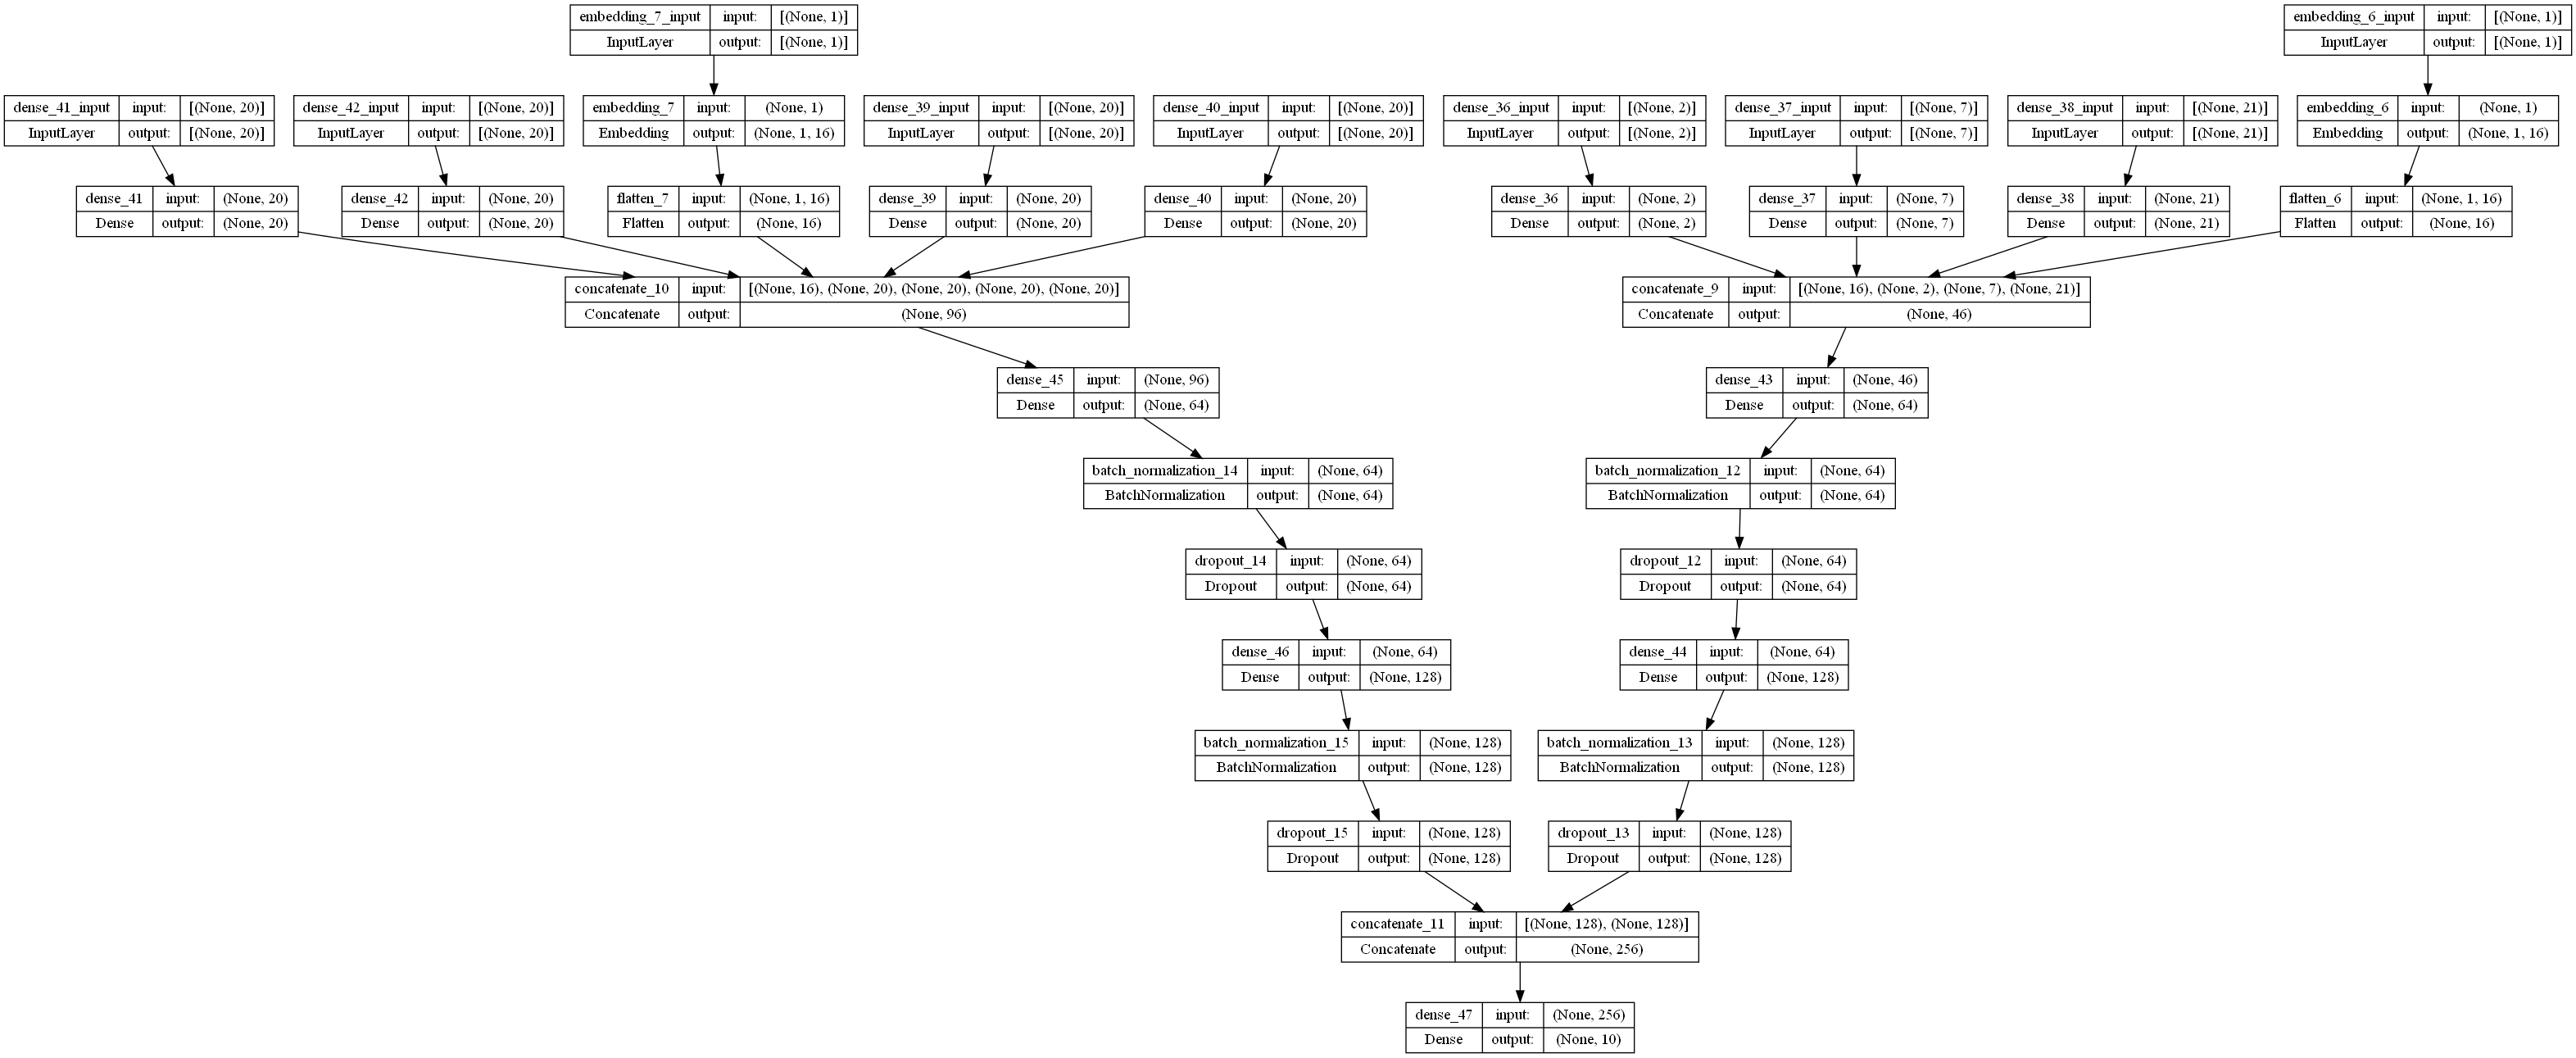

In [34]:
from keras.utils.vis_utils import plot_model


# plot the model architecture
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


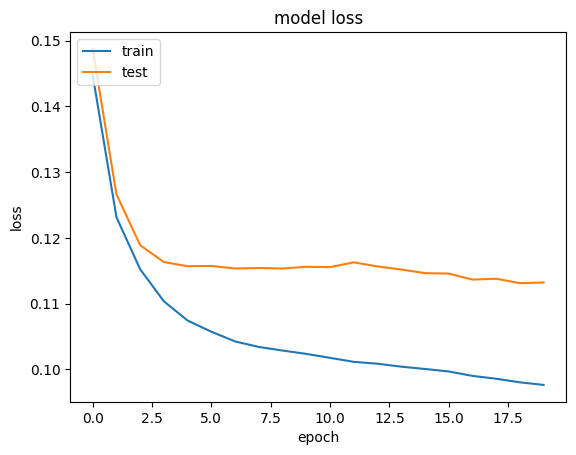

In [33]:
plt.plot( history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Rough

ratings.columns : Index(['userId', 'movieId', 'rating', 'timestamp', 'zipcode', 'gender_F',
       'gender_M', 'age_1', 'age_18', 'age_25', 'age_35', 'age_45', 'age_50',
       'age_56', 'occupationId_0', 'occupationId_1', 'occupationId_2',
       'occupationId_3', 'occupationId_4', 'occupationId_5', 'occupationId_6',
       'occupationId_7', 'occupationId_8', 'occupationId_9', 'occupationId_10',
       'occupationId_11', 'occupationId_12', 'occupationId_13',
       'occupationId_14', 'occupationId_15', 'occupationId_16',
       'occupationId_17', 'occupationId_18', 'occupationId_19',
       'occupationId_20'],
      dtype='object')


Index(['cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5', 'cast_6', 'cast_7',
       'cast_8', 'cast_9', 'cast_10', 'cast_11', 'cast_12', 'cast_13',
       'cast_14', 'cast_15', 'cast_16', 'cast_17', 'cast_18', 'cast_19',
       'cast_20'],
      dtype='object')


Index(['director_1', 'director_2', 'director_3', 'director_4', 'director_5',
       'director_6', 'director_7', 'director_8', 'director_9', 'director_10',
       'director_11', 'director_12', 'director_13', 'director_14',
       'director_15', 'director_16', 'director_17', 'director_18',
       'director_19', 'director_20'],
      dtype='object')
      


Index(['production_companies_1', 'production_companies_2',
       'production_companies_3', 'production_companies_4',
       'production_companies_5', 'production_companies_6',
       'production_companies_7', 'production_companies_8',
       'production_companies_9', 'production_companies_10',
       'production_companies_11', 'production_companies_12',
       'production_companies_13', 'production_companies_14',
       'production_companies_15', 'production_companies_16',
       'production_companies_17', 'production_companies_18',
       'production_companies_19', 'production_companies_20'],
      dtype='object')

